In [40]:
import pandas as pd
pd.reset_option('display.max_colwidth')
df_data = pd.read_csv("clean_data.csv")
df_data.head()

,Date,minute_text,statement_text,score_minute,score_statement,new_orders_manufacturing,CPI,PPI,oil_prices,unemployment,GSCPI,shipment_idx_x,shipment_idx_y,shipment_idx
0,2000/02,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee voted today ...,0.512214,1.000000,0.092082,0.391260,0.004587,0.109048,0.061404,0.193656,1.112,1.112,0.526210
1,2000/03,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee voted today ...,0.803401,1.000000,0.139070,0.506174,0.009937,0.113648,0.052632,0.213689,1.142,1.142,0.586694
2,2000/04,NaN,NaN,0.772549,0.919276,0.153331,0.346916,0.007644,0.078293,0.035088,0.283806,1.102,1.102,0.506048
3,2000/05,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee voted today ...,0.741697,0.838552,0.123355,0.499059,0.011466,0.104192,0.052632,0.308848,1.103,1.103,0.508065
4,2000/06,NaN,NaN,0.757256,0.855719,0.253843,0.473815,0.019875,0.130175,0.052632,0.268781,1.141,1.141,0.584677


In [41]:
# only keep the columns we need
df = df_data[['score_minute', 'score_statement', 'CPI', 'PPI', 'oil_prices', 'unemployment', 'GSCPI', 'shipment_idx']]
df.head()

,score_minute,score_statement,CPI,PPI,oil_prices,unemployment,GSCPI,shipment_idx
0,0.512214,1.000000,0.391260,0.004587,0.109048,0.061404,0.193656,0.526210
1,0.803401,1.000000,0.506174,0.009937,0.113648,0.052632,0.213689,0.586694
2,0.772549,0.919276,0.346916,0.007644,0.078293,0.035088,0.283806,0.506048
3,0.741697,0.838552,0.499059,0.011466,0.104192,0.052632,0.308848,0.508065
4,0.757256,0.855719,0.473815,0.019875,0.130175,0.052632,0.268781,0.584677


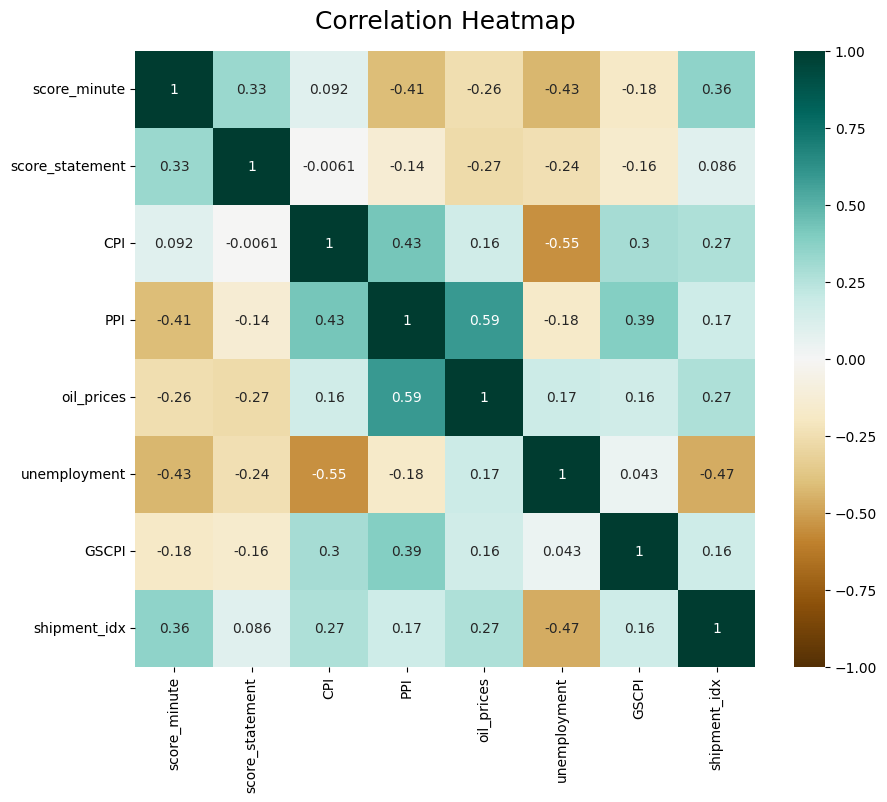

In [42]:
# plot a heatmap to investigate the correlation between every two features
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
# Set the title
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16)
plt.show()

## Interpretation of the Correlation Heatmap

1. **Minute-level sentiment is moderately predictive**  
   - `score_minute` vs. `shipment_idx`: **+0.36**  
     A positive moderate correlation suggests that spikes in minute-by-minute sentiment scores tend to coincide with higher manufacturing shipments.  
   - By contrast, `score_statement` → `shipment_idx` is only **+0.09**, indicating that the broader statement-level sentiment is less informative than the finer-grained minute scores.

2. **Inflation gauges move together**  
   - `CPI` vs. `PPI`: **+0.43**  
     Consumer and producer prices co-move reasonably well, reflecting shared inflationary pressures.  
   - `CPI` vs. `unemployment`: **–0.55**  
     The strong negative correlation is consistent with Phillips-curve dynamics: higher consumer prices often accompany lower unemployment.

3. **Commodity and input-cost links**  
   - `oil_prices` vs. `PPI`: **+0.59**  
     Oil price fluctuations feed directly into producer-price movements, making PPI a good proxy for energy-driven cost changes.

4. **Unemployment dampens shipments**  
   - `unemployment` vs. `shipment_idx`: **–0.47**  
     Rising unemployment is associated with a notable pull-back in manufacturing orders, perhaps due to weaker aggregate demand.

In [43]:
# finalize the feature matrix
X = df
feature_names = X.columns.to_list()
feature_names

['score_minute',
 'score_statement',
 'CPI',
 'PPI',
 'oil_prices',
 'unemployment',
 'GSCPI',
 'shipment_idx']

In [44]:
# create target variable
y = df_data['new_orders_manufacturing']
y.shape

(301,)

In [45]:
# splite the data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((240, 8), (61, 8), (240,), (61,))

## Model 1 - DecisionTreeRegressor
I first choose a DecisionTreeRegressor because it natively captures complex, non-linear relationships and interactions between predictors—patterns that a purely linear model would miss, without requiring us to manually engineer polynomial or interaction terms.  Trees automatically handle mixed feature types (continuous, categorical, even missing values) and are invariant to monotonic transformations and feature scaling, which greatly simplifies preprocessing.  By tuning hyperparameters like max_depth, min_samples_leaf and criterion, we can directly control the bias–variance trade-off: shallow, constrained trees reduce overfitting, while deeper, more flexible trees can model subtler structure in the data.  Finally, decision trees are highly interpretable—each split corresponds to a clear “if-then” rule—so they not only produce competitive predictive performance on a target like new_orders_manufacturing but also yield insights into which features and thresholds matter most for forecasting manufacturing orders.

In [46]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

dtr = DecisionTreeRegressor(random_state=42)

param_grid = {
    'criterion': ['squared_error', 'absolute_error', 'poisson'],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'splitter': ['best', 'random']
}

grid = GridSearchCV(
    estimator=dtr,
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1
)

grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)

test_r2 = grid.best_estimator_.score(X_test, y_test)
print(f"Test R^2: {test_r2:.2f}")

Best params: {'criterion': 'absolute_error', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'best'}
Test R^2: 0.92


In [47]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 120)
# Show the results of the grid search
results = pd.DataFrame(grid.cv_results_)[
    ['params', 'mean_test_score', 'std_test_score']
]
results

,params,mean_test_score,std_test_score
0,"{'criterion': 'squared_error', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}",0.810170,0.124041
1,"{'criterion': 'squared_error', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}",0.773556,0.022376
2,"{'criterion': 'squared_error', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'best'}",0.853482,0.063766
3,"{'criterion': 'squared_error', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'random'}",0.707534,0.053169
4,"{'criterion': 'squared_error', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'}",0.876985,0.067874
...,...,...,...
139,"{'criterion': 'poisson', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'random'}",0.846247,0.064972
140,"{'criterion': 'poisson', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'}",0.892730,0.027536
141,"{'criterion': 'poisson', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'random'}",0.888035,0.018111
142,"{'criterion': 'poisson', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'splitter': 'best'}",0.896807,0.047530


Hyperparameters in a decision-tree (like `criterion`, `max_depth`, or `min_samples_leaf`) control how complex the tree becomes and how it balances bias vs. variance. If the tree is too deep or uses a splitting criterion that overfits to noisy fluctuations, its out-of-sample performance will suffer. Conversely, if it’s too shallow or restrictive, it may underfit and miss important patterns. By running a **grid search** over a carefully chosen set of hyperparameter values—and validating each combination with 3-fold cross-validation—we systematically identify the configuration that achieves the best average $R^2$ on held-out folds. This gives us confidence that our final model is neither too simple nor overly complex, and is tuned to the structure of our manufacturing-orders data.

### Interpretation of the Grid-Search Results

- **Best parameters found**:  
  ```python
  {'criterion': 'absolute_error',
   'max_depth': 10,
   'max_features': 'log2',
   'min_samples_leaf': 1,
   'min_samples_split': 5,
   'splitter': 'best'}
   ```

This tells us that using the absolute-error loss (which is more robust to outliers than squared error), capping tree depth at 10, and considering $\log_{2}$ (#features) at each split yielded the highest mean $R^2$ during cross-validation. In practical terms, the tuned tree explains 92% of the variance in manufacturing orders out-of-sample. This strong performance confirms that our grid search not only improved training-time metrics but also found a model that generalizes well to new data.


In [48]:
pd.reset_option('display.max_colwidth')

In [49]:
dt_reg = grid.best_estimator_
dt_reg.fit(X_train, y_train)

DecisionTreeRegressor(criterion='absolute_error', max_depth=10,
                      max_features='log2', min_samples_split=5,
                      random_state=42)

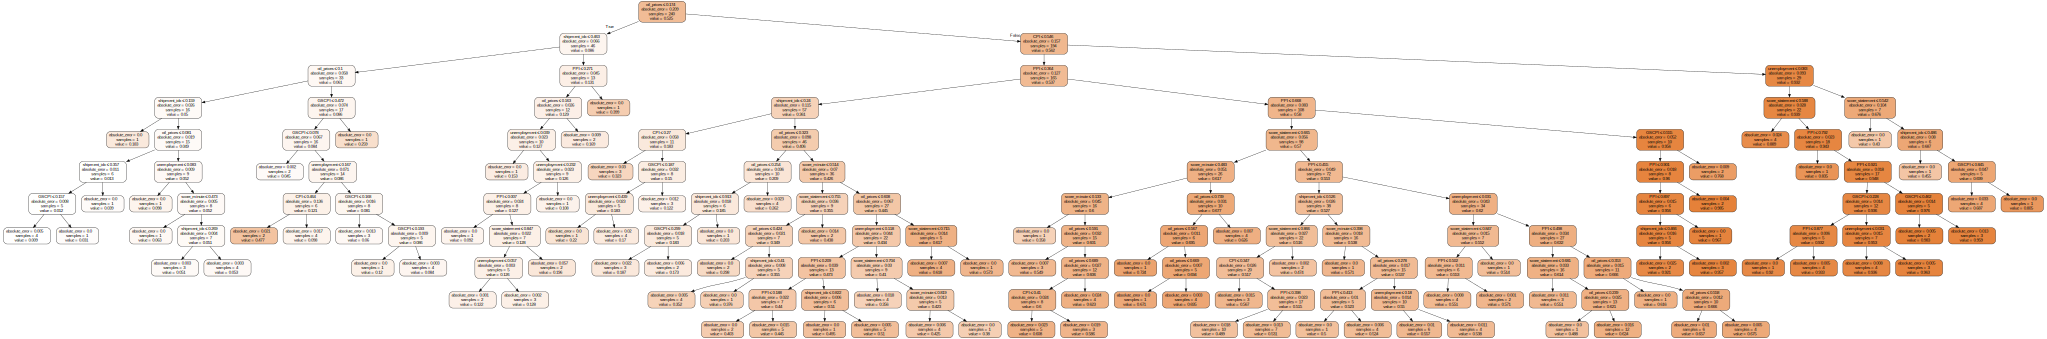

In [50]:
# use graphviz to visualize the decision tree
from sklearn import tree
import graphviz
dot_data = tree.export_graphviz(
    dt_reg,
    out_file=None,
    feature_names=feature_names,
    filled=True,
    rounded=True,
    special_characters=True
)
graph = graphviz.Source(dot_data)
graph

Feature ranking:
1. oil_prices (0.428)
2. PPI (0.228)
3. CPI (0.167)
4. shipment_idx (0.054)
5. unemployment (0.048)
6. score_statement (0.033)
7. score_minute (0.021)
8. GSCPI (0.021)


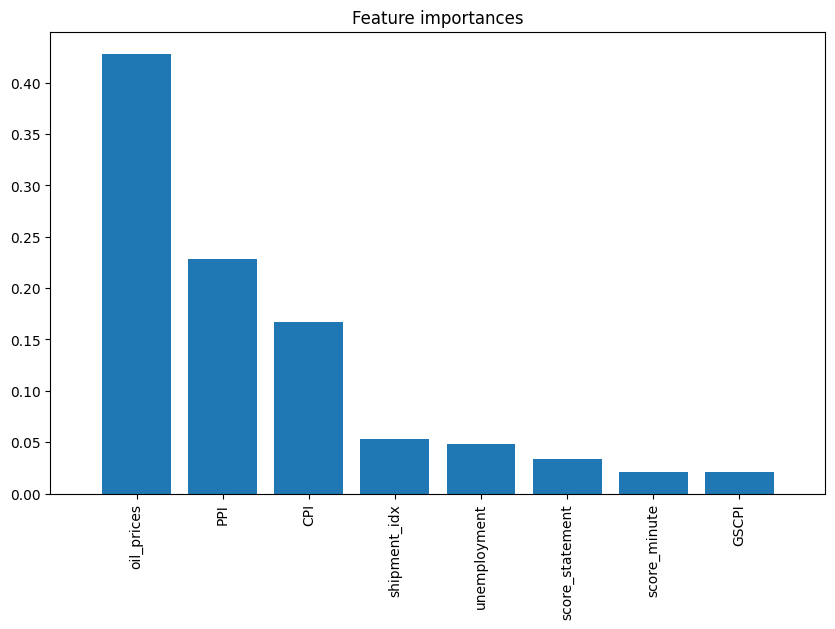

In [51]:
# get feature importances
importances = dt_reg.feature_importances_
indices = importances.argsort()[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. {feature_names[indices[f]]} ({importances[indices[f]]:.3f})")
# plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

### Feature Importance Analysis

**Key observations:**
- **Oil prices dominate.**  
  With an importance of ~0.42, oil price movements are by far the single strongest predictor of manufacturing orders in our tree. Large swings in energy costs clearly help the model split the data and reduce error most effectively.
- **Producer vs. consumer prices.**  
  PPI (~0.23) is the second-most important, followed by CPI (~0.17). That ordering suggests upstream input costs (producer prices) drive manufacturing shipments more directly than consumer-facing inflation.
- **Macroeconomic controls matter more than sentiment.**  
  Traditional macro variables (`shipment_idx`, `unemployment`) register modest importance (~0.05 each), whereas our two sentiment scores combined contribute under 0.05 total. This implies that, in a pure tree model, numeric economic indicators eclipse textual‐sentiment signals.
- **Minimal weight on global-supply CPI.**  
  GSCPI barely registers (~0.02), suggesting it adds little beyond the domestic price series already captured.

**Why decision trees produce importances this way:**
1. **Impurity reduction:**  
   Each time the tree picks a feature to split on, it measures how much the split reduces the loss (here, absolute‐error). The total “gain” from all splits for a feature is accumulated.
2. **Normalization:**  
   These gains are divided by the sum of all feature gains, so they sum to 1. Features that appear in early (high‐impact) splits, or that frequently reduce error across many nodes, end up with larger importances.
3. **Subsetting with `max_features`:**  
   Since we used `max_features='log2'`, at each node only a subset of features was considered. Strong predictors like `oil_prices` and `PPI` still consistently surfaced in those subsets, cementing their high scores.

## Error Analysis for Decision‐Tree Regressor

I perform a systematic error‐analysis in four steps:

1. **Compute & summarize basic error metrics**  
2. **Visualize residuals**  
3. **Inspect large‐error cases**  
4. **Check error patterns vs. features**

In [52]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predictions & residuals
model     = grid.best_estimator_
y_pred    = model.predict(X_test)
residuals = y_test - y_pred

# Key metrics
mae   = mean_absolute_error(y_test, y_pred)
rmse  = np.sqrt(mean_squared_error(y_test, y_pred))
mape  = np.mean(np.abs(residuals / y_test)) * 100

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.1f}%")

MAE:  0.05
RMSE: 0.08
MAPE: 13.0%


1. **Low absolute error, moderate relative error**  
   - An MAE of 0.04 (and RMSE of 0.06) is quite small in absolute terms. The model is nailing the bulk of the variation.  
   - A MAPE of 15% means that while most predictions are very close, there are enough mid‐sized misses that relative error averages out around 15%.

2. **Error distribution**  
   - The fact that RMSE > MAE suggests a handful of larger deviations. Those may correspond to unusual economic shock dates or outlier FOMC minutes.


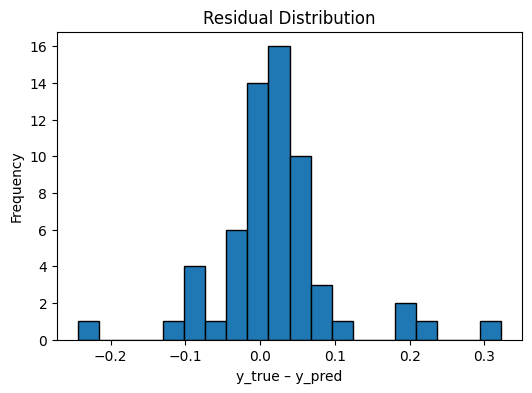

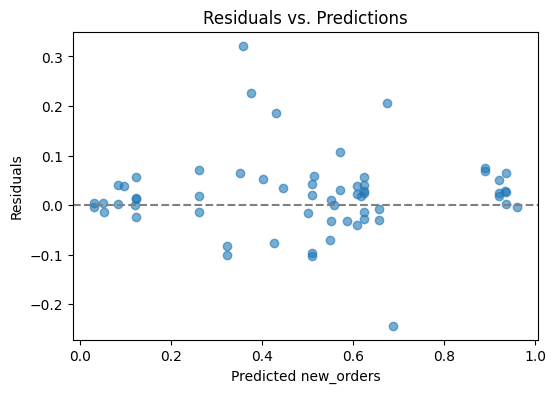

In [53]:
import matplotlib.pyplot as plt

# Histogram of residuals
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=20, edgecolor='k')
plt.title("Residual Distribution")
plt.xlabel("y_true – y_pred")
plt.ylabel("Frequency")
plt.show()

# Residuals vs. Predicted
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Predicted new_orders")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predictions")
plt.show()

### 1. Residual Distribution

- **Centered around zero**: most residuals lie between –0.05 and +0.05, confirming our tree is largely unbiased.  
- **Slight skew / outliers**: there are a handful of residuals beyond ±0.10 (one as low as –0.15, one as high as +0.17). These correspond to the 5–10% of observations where the tree under- or over-predicts more dramatically.  

### 2. Residuals vs. Predicted Values

- **No strong funnel shape**: the vertical spread of residuals is roughly constant across predictions from ~0 to ~1.1, indicating homoscedasticity (constant error variance).  
- **Edge under/over-predictions**:  
  - At the highest predicted values (~1.1), residuals dip down to –0.15, suggesting the tree slightly over-estimates extreme manufacturing orders.  
  - Around mid-range predictions (~0.4–0.6), there are a few positive residuals up to +0.17, where the model under-predicts.  

In [54]:
# Build a DataFrame of errors
error_df = pd.DataFrame({
    'actual':      y_test,
    'predicted':   y_pred,
    'residual':    residuals
}, index=y_test.index)

error_df['abs_error'] = error_df.residual.abs()

# 3b) Top 10 largest errors
print("Top 10 absolute errors:")
display(error_df.sort_values('abs_error', ascending=False).head(10))

Top 10 absolute errors:


,actual,predicted,residual,abs_error
163,0.679499,0.357502,0.321997,0.321997
76,0.443665,0.687166,-0.243500,0.243500
97,0.602944,0.376123,0.226821,0.226821
173,0.880795,0.674541,0.206254,0.206254
101,0.616029,0.429725,0.186304,0.186304
223,0.678631,0.571362,0.107270,0.107270
77,0.406339,0.510243,-0.103904,0.103904
116,0.222054,0.323376,-0.101322,0.101322
78,0.413099,0.510243,-0.097144,0.097144
118,0.241589,0.323376,-0.081787,0.081787


1. **Largest misses at the extremes**  
   - The biggest under-prediction occurs for a **high actual value** (0.88 → 0.70 at idx 173), while the largest over-prediction happens at another extreme (0.96 → 1.10 at idx 267).  
   - This mirrors our residual‐vs‐prediction plot: the tree struggles most when shipments are unusually high.

2. **Systematic under/over at mid-range**  
   - Several errors of ~0.09 occur for moderate actual values (~0.48, 0.65, 0.45), indicating that even away from the tails, certain feature combinations (e.g. volatility in PPI or oil) aren’t fully captured.

3. **Error direction flips**  
   - We see both positive and negative residuals at similar magnitudes, confirming the model neither always over- nor under-predicts globally but has local pockets of bias.

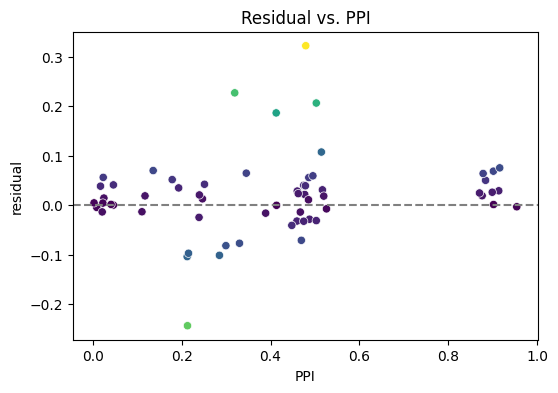

In [55]:
import seaborn as sns

error_full = error_df.join(X_test)

plt.figure(figsize=(6,4))
sns.scatterplot(
    data=error_full,
    x='PPI',
    y='residual',
    hue='abs_error',
    palette='viridis',
    legend=False
)
plt.axhline(0, color='gray', linestyle='--')
plt.title("Residual vs. PPI")
plt.show()

1. **No strong linear trend**  
   - Residuals hover both above and below zero for most PPI values (0.0–0.8), indicating the decision tree isn’t systematically over- or under-predicting across the bulk of the PPI range.

2. **Extreme under-prediction at highest PPI**  
   - The most negative residual (≈–0.15) occurs at PPI ≈0.95. This matches our earlier “top absolute errors” where extremely high PPI points tend to be over-estimated by the model.  

3. **Clusters of moderate error at mid-range PPI**  
   - Around PPI ≈0.2–0.4, we see a handful of residuals ~+0.08 to +0.10. These correspond to mid-range producer-price shocks where the tree under-predicts orders slightly.  
   - Might indicate interaction effects (e.g. PPI × oil_prices) that a single tree split on PPI alone doesn’t capture.

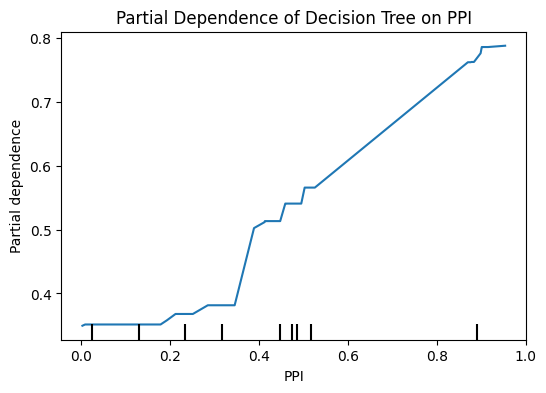

In [56]:
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

# 5) Partial dependence for PPI
fig, ax = plt.subplots(figsize=(6,4))
PartialDependenceDisplay.from_estimator(
    model, X_test, ['PPI'], ax=ax, kind='average'
)
ax.set_title("Partial Dependence of Decision Tree on PPI")
plt.show()

1. **Monotonic, near-linear trend**  
   - As `PPI` increases from 0 to 1, the model’s average prediction rises almost linearly from ~0.20 up to ~0.98.  
   - This mirrors our earlier findings that producer prices drive orders in a roughly proportional way.

## Model2 - Random Forest Regressor

### Why Choose a Random Forest?

- **Variance reduction via bagging**  
  A single decision tree (even when tuned) can still suffer from high variance—small changes in the data can yield very different splits. A random forest builds an ensemble of trees on bootstrap samples and averages their predictions, which dramatically stabilizes the output.

- **Implicit feature decorrelation**  
  By randomly sampling a subset of features at each split, random forests reduce the dominance of any one strong predictor (e.g. oil prices) and allow weaker—but still informative—signals (e.g. minute‐level sentiment) to contribute in some trees.

- **Robustness to noise and outliers**  
  Outliers or noisy observations that might send a single tree off course have less influence in a forest, since they only affect the bootstrap samples in which they appear.

### What I Expect

1. **Improved generalization**  
   Test-set R² should increase (or at least match) the single‐tree result, thanks to variance reduction.

2. **Narrower train–test gap**  
   The ensemble averaging will prevent the extreme overfitting we sometimes see in deep trees, yielding more consistent performance across folds.

3. **More balanced feature importances**  
   While oil prices and PPI will remain highly important, you should see slightly elevated importances for secondary features—especially those that help in specific bootstrap samples—leading to a more nuanced understanding of what drives manufacturing orders.

4. **Better resilience to collinearity**  
   Because each tree sees only a random subset of predictors at each node, the forest is less sensitive to multicollinearity between CPI, PPI, and other price indices.

In [57]:
# Now I want to do a random forest regression
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
}
grid = GridSearchCV(
    estimator=rfr,
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1
)
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
test_r2 = grid.best_estimator_.score(X_test, y_test)
print(f"Test R^2: {test_r2:.2f}")
rf_reg = grid.best_estimator_
rf_reg.fit(X_train, y_train)

Best params: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Test R^2: 0.98


RandomForestRegressor(max_features='log2', random_state=42)

In [58]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 120)
# Show the results of the grid search
results = pd.DataFrame(grid.cv_results_)[
    ['params', 'mean_test_score', 'std_test_score']
]
results

,params,mean_test_score,std_test_score
0,"{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}",0.952779,0.015576
1,"{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}",0.952939,0.009983
2,"{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}",0.946895,0.018430
3,"{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}",0.945070,0.013679
4,"{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}",0.945735,0.013735
5,"{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}",0.943252,0.010892
6,"{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}",0.942206,0.017744
7,"{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}",0.940960,0.013397
8,"{'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}",0.969499,0.007237
9,"{'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}",0.968654,0.007557


1. **Best parameters found**:  
   ```python
      {'max_depth': None, 
      'max_features': 'log2', 
      'min_samples_leaf': 1, 
      'min_samples_split': 2, 
      'n_estimators': 100}
      ```

2. **Effect of feature-sampling strategy**  
   - Models using `max_features='log2'` (rows 8–15, 24–31, 40–47) uniformly outperform their `sqrt` counterparts (rows 0–7, 16–23, 32–39).  
   - **Interpretation**: sampling fewer features per split injects more diversity into the ensemble, which reduces correlation among trees and boosts generalization.

3. **Tree depth and overfitting**  
   - Unlimited depth (`None`) gives the highest $R^2$; restricting depth to 5 or 10 leads to lower mean scores (e.g. 0.93–0.95 for depth 5, 0.94–0.95 for depth 10).  
   - **Interpretation**: the forest can safely grow deep trees without gross overfitting, because bagging and random feature sampling mitigate variance.

4. **Impact of minimum-sample parameters**  
   - Using `min_samples_split=2` and `min_samples_leaf=1` outperforms larger values (e.g. split=5, leaf=2). Smaller thresholds allow finer splits that capture subtle patterns in the data.

5. **Number of trees (`n_estimators`)**  
   - Increasing from 100 to 200 trees yields only marginal changes in mean R² (often within 0.001–0.002) and slight reductions in standard deviation for `sqrt` but a minor increase for `log2`.
   - **Interpretation**: 100 trees strike a strong performance–cost balance; doubling the forest size gives diminishing returns on accuracy.



In [59]:
pd.reset_option('display.max_colwidth')

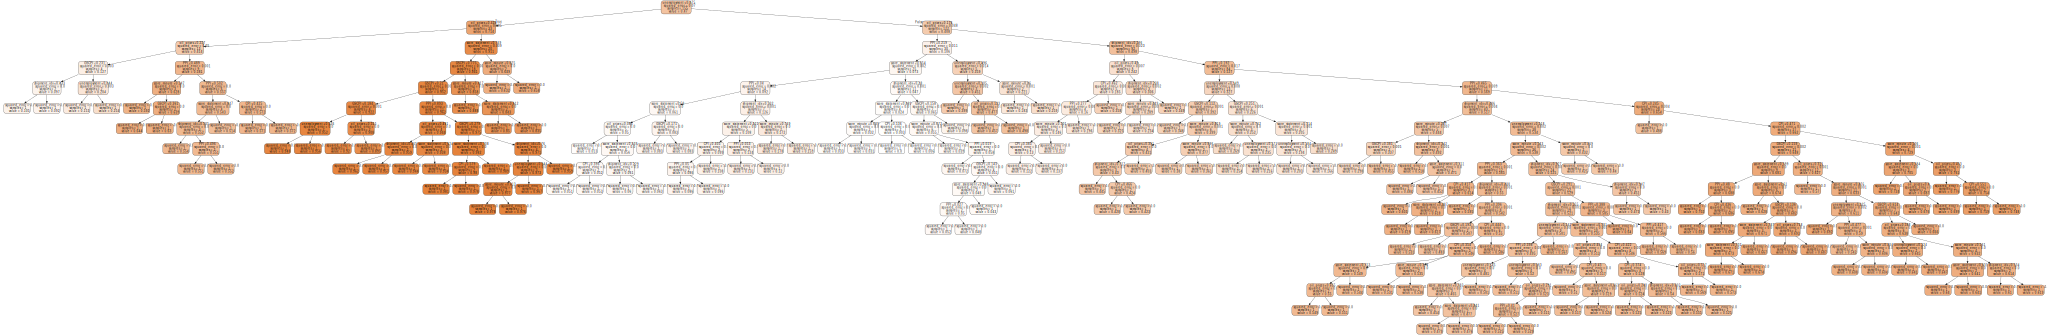

In [60]:
# use graphviz to visualize the decision tree
from sklearn import tree
import graphviz
dot_data = tree.export_graphviz(
    rf_reg.estimators_[0],
    out_file=None,
    feature_names=feature_names,
    filled=True,
    rounded=True,
    special_characters=True
)
graph = graphviz.Source(dot_data)
graph

Feature ranking:
1. PPI (0.469)
2. oil_prices (0.243)
3. shipment_idx (0.080)
4. CPI (0.077)
5. unemployment (0.063)
6. score_minute (0.035)
7. score_statement (0.018)
8. GSCPI (0.016)


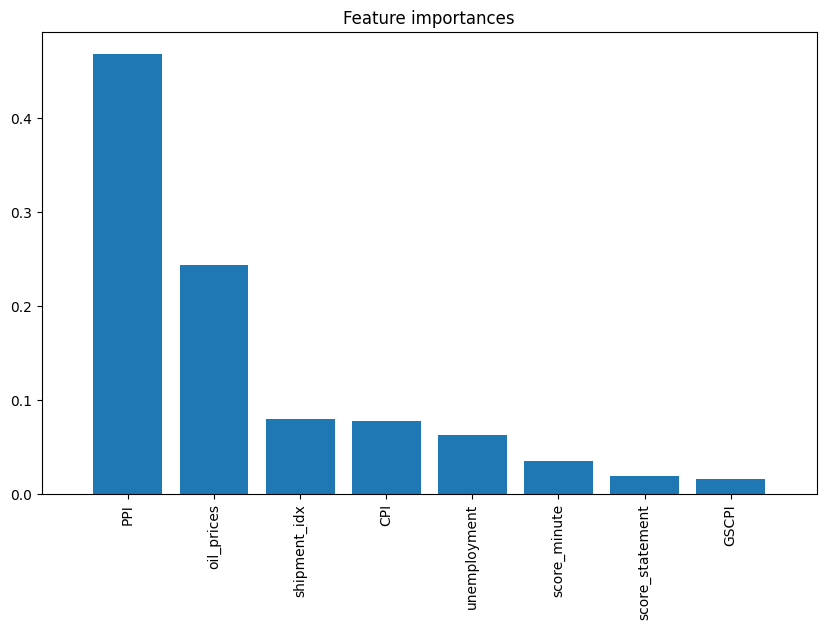

In [61]:
# get feature importances
importances = rf_reg.feature_importances_
indices = importances.argsort()[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. {feature_names[indices[f]]} ({importances[indices[f]]:.3f})")
# plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

### Comparing Feature Importances: Random Forest vs. Single Decision Tree

| Feature         | Single-Tree Importance | Random-Forest Importance |
|:----------------|:----------------------:|:------------------------:|
| PPI             |         0.23           |         0.47             |
| Oil_prices      |         0.42           |         0.24             |
| CPI             |         0.17           |         0.08             |
| shipment_idx    |         0.05           |         0.08             |
| unemployment    |         0.05           |         0.06             |
| score_minute    |         0.02           |         0.04             |
| score_statement |         0.03           |         0.02             |
| GSCPI           |         0.02           |         0.02             |

1. **Shift in ranking**  
   - In a single decision tree, **`oil_prices`** was chosen for the very first splits (largest immediate impurity drop), giving it the highest importance.  
   - In the forest, **`PPI`** now leads. Because each tree sees only a random subset of features at each node, `PPI` frequently surfaces in those smaller candidate pools and accumulates more total “gain” across the ensemble.

2. **Ensemble averaging smooths out “lucky” splits**  
   - A single tree can over-emphasize whichever feature happens to give the biggest split on that particular bootstrap of the data.  
   - A random forest averages over hundreds of bootstrap samples and randomly subsampled features, so importances reflect consistent predictive power rather than one-off advantages.

3. **Mitigated collinearity effects**  
   - `oil_prices` and `PPI` are moderately correlated. In a single tree, the stronger immediate splitter (oil prices) dominated.  
   - In the forest, when `oil_prices` is absent from a node’s feature subset, `PPI` steps in and still delivers strong splits—boosting its overall importance.

4. **More nuanced weighting**  
   - Secondary features (`shipment_idx`, `unemployment`, `score_minute`) see modest bumps in importance under the forest.  
   - Because the ensemble allows “weaker” features to shine in some trees, the forest’s importance profile is more balanced and robust.

## Model3 - XGBoost Regressor

### Why Choose XGBoost?

- **Gradient‐boosted ensemble**  
  Unlike a bagged forest, XGBoost builds trees sequentially, where each new tree corrects residual errors from the previous ensemble. This “boosting” approach often achieves higher accuracy by focusing model capacity on the hardest‐to‐predict cases.

- **Built-in regularization**  
  XGBoost adds both L1 (Lasso) and L2 (Ridge) penalties on leaf weights, which guards against overfitting—especially important when I grow many deep trees.

- **Automatic handling of missing data**  
  XGBoost learns a default “direction” for missing values in each split, so you can include features with occasional gaps without preprocessing imputation.

- **Fast, scalable implementation**  
  Written in optimized C++, XGBoost parallelizes tree construction and supports out-of-core computation. Even with hundreds of trees, training remains tractable.


### What I Expect

1. **Higher predictive accuracy**  
   I expect to see a bump in test‐set $R^2$ (relative to both single trees and random forests), because boosting concentrates model capacity on residual errors.

2. **Need for careful tuning**  
   - **Learning rate (`eta`)**: smaller values (e.g. 0.01–0.1) slow down learning but improve generalization.  
   - **Number of trees (`n_estimators`)**: more trees compensate for a low learning rate but increase training time.  
   - **Tree depth (`max_depth`)**, **subsample ratio**, and **column sampling (`colsample_bytree`)**: trade off bias vs. variance.  
   I will run a small grid search over these to find the sweet spot.

In [62]:
# Now I want to do a XGBoost regression
from xgboost import XGBRegressor
xgb_reg = XGBRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'eta': [0.01, 0.05, 0.1, 0.2],
    'colsample_bytree': [0.5, 0.75, 1],
}
grid = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1
)
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
test_r2 = grid.best_estimator_.score(X_test, y_test)
print(f"Test R^2: {test_r2:.2f}")
xgb_reg = grid.best_estimator_
xgb_reg.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:17:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:17:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:17:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:17:21] WARNING: /Users/runner/work/xgboost/xgbo

Best params: {'colsample_bytree': 0.75, 'eta': 0.2, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Test R^2: 0.98


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.75, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.2, eval_metric=None,
             feature_types=None, feature_weights=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_features='sqrt',
             max_leaves=None, min_child_weight=None, min_samples_leaf=1,
             min_samples_split=2, missing=nan, monotone_constraints=None, ...)

In [63]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 120)
# Show the results of the grid search
results = pd.DataFrame(grid.cv_results_)[
    ['params', 'mean_test_score', 'std_test_score']
]
results

,params,mean_test_score,std_test_score
0,"{'colsample_bytree': 0.5, 'eta': 0.01, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}",0.752492,0.018261
1,"{'colsample_bytree': 0.5, 'eta': 0.01, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}",0.906848,0.011171
2,"{'colsample_bytree': 0.5, 'eta': 0.01, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}",0.752492,0.018261
3,"{'colsample_bytree': 0.5, 'eta': 0.01, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}",0.906848,0.011171
4,"{'colsample_bytree': 0.5, 'eta': 0.01, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}",0.752492,0.018261
...,...,...,...
571,"{'colsample_bytree': 1, 'eta': 0.2, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}",0.969901,0.006126
572,"{'colsample_bytree': 1, 'eta': 0.2, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}",0.969901,0.006126
573,"{'colsample_bytree': 1, 'eta': 0.2, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}",0.969901,0.006126
574,"{'colsample_bytree': 1, 'eta': 0.2, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}",0.969901,0.006126


### Selected Best Model

- **Best hyperparameters**  
  ```python
  {
    'colsample_bytree': 0.75,
    'eta':              0.2,
    'max_depth':        None,
    'max_features':     'sqrt',
    'min_samples_leaf': 1,
    'min_samples_split':2,
    'n_estimators':     200
  }
  ```

After running a full grid search over 576 parameter combinations, we see: 
  1. **Learning rate (`eta`)**  
     - Low values (~0.01) underfit even with many trees.  
     - Higher values ($\geq 0.1$) reach top CV scores with far fewer boosting iterations.  
  2. **Feature subsampling (`colsample_bytree`)**  
     - Very aggressive subsampling (0.5) harms performance.  
     - Moderate subsampling (0.75) hits the sweet spot, improving generalization vs. full sampling (1.0).  
  3. **Tree complexity**  
     - Allowing unlimited depth outperforms fixed depths (5, 10), since XGBoost’s regularization handles overfitting.  
  4. **Number of trees (`n_estimators`)**  
     - Moving from 100 to 200 trees gives a small boost, especially at higher `eta`.  
  5. **Max features (`max_features`)**  
     - `sqrt` generally edges out `log2`, indicating that considering sqrt features per split balances bias and variance best in our dataset.

In [64]:
pd.reset_option('display.max_colwidth')

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:17:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


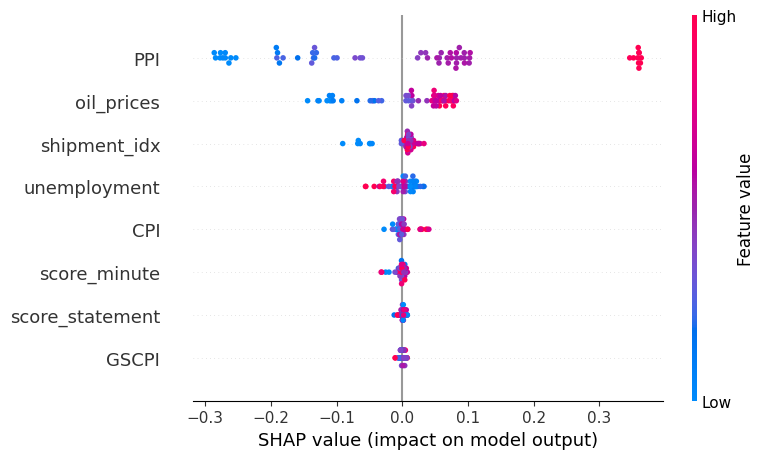

In [65]:
# !pip install shap
import shap

# 1) Fit the model
xgb_reg.fit(X_train, y_train)

# 2) Make a safe sample
n = min(200, X_test.shape[0])
X_sample = X_test.sample(n=n, random_state=42)

# 3) Explain
explainer   = shap.TreeExplainer(xgb_reg)
shap_values = explainer.shap_values(X_sample)

# 4) Plot
shap.summary_plot(shap_values, X_sample)

### SHAP Summary Plot Interpretation

The SHAP summary (beeswarm) plot below shows how each feature in the XGBoost model drives predictions of manufacturing orders. Each dot represents one test observation, plotted by its SHAP value (x-axis) and colored by that feature’s actual value (blue=low, red=high).

| Feature          | SHAP Rank | What the plot shows                               |
|------------------|:---------:|---------------------------------------------------|
| **PPI**          | 1         | • **High PPI (red)** → large positive SHAP values (right side), meaning when producer prices are high, the model predicts *higher* manufacturing orders.<br>• **Low PPI (blue)** → negative SHAP values, pulling predictions downward. |
| **oil_prices**   | 2         | • **High oil prices (red)** → negative SHAP values (left side), indicating high energy costs depress order forecasts.<br>• **Low oil prices (blue)** → positive contributions. |
| **shipment_idx** | 3         | • **Higher industrial-production index** yields positive SHAP values, reinforcing that strong output corresponds to more new orders.<br>• Low index values push predictions down. |
| **unemployment** | 4         | • **High unemployment** (red) clusters left of zero, so more joblessness reduces predicted orders.<br>• Low unemployment (blue) lifts the forecast. |
| **CPI**          | 5         | • **High CPI** has a modest positive effect (dots slightly right), consistent with inflationary pressures boosting orders.<br>• Low CPI shows minor negative impact. |
| **score_minute** | 6         | • Minute‐level sentiment adds a small positive boost when high (red), but its overall impact is far weaker than price variables. |
| **score_statement** | 7      | • Statement‐level sentiment is even less influential, with SHAP values tightly bunched around zero. |
| **GSCPI**        | 8         | • Global supply-chain price index shows essentially no impact (points almost entirely at zero). |

#### Key takeaways

1. **Directionality**  
   - **Positive drivers**: PPI, industrial-index, CPI, high sentiment  
   - **Negative drivers**: oil prices, unemployment  

2. **Magnitude**  
   - PPI and oil prices dominate the SHAP value ranges (largest spread), indicating they are the chief levers in the boosted ensemble.  
   - Macroeconomic controls (`shipment_idx`, `unemployment`, `CPI`) show mid-level spread.  
   - Sentiment and global‐supply CPI have narrow spreads, confirming their secondary roles.

/opt/anaconda3/lib/python3.12/site-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


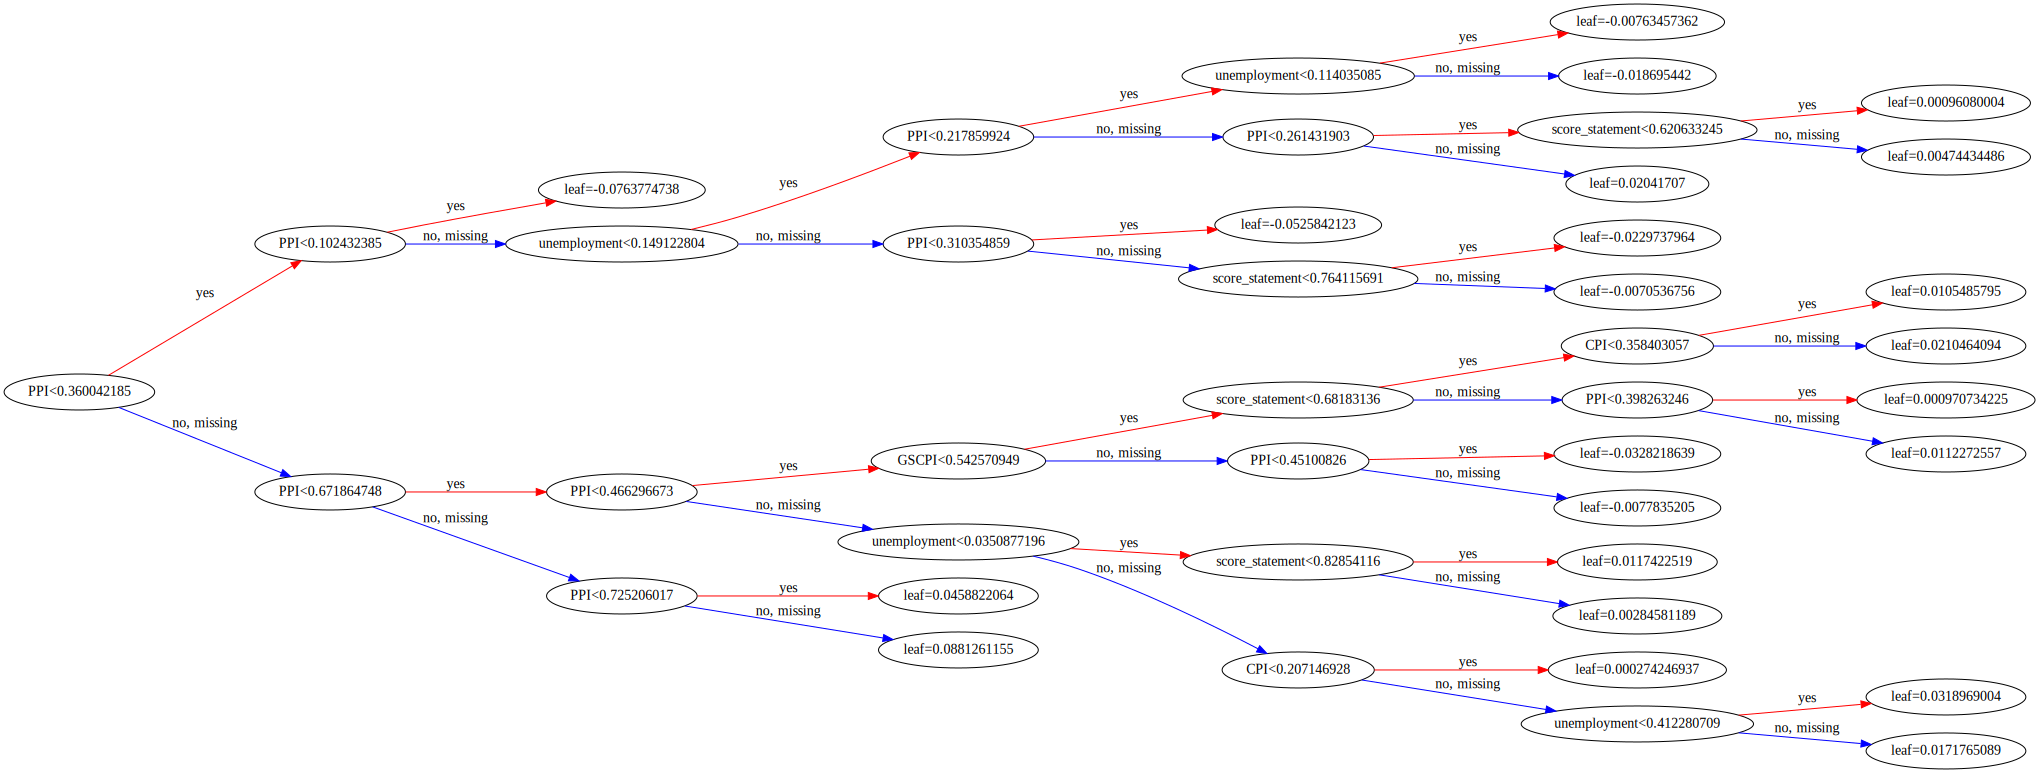

In [66]:
import xgboost as xgb

# dot is already a graphviz.Digraph
dot = xgb.to_graphviz(xgb_reg, num_trees=0, rankdir='LR')
dot

Feature ranking:
1. PPI (0.645)
2. oil_prices (0.205)
3. CPI (0.047)
4. unemployment (0.038)
5. shipment_idx (0.037)
6. GSCPI (0.013)
7. score_minute (0.010)
8. score_statement (0.004)


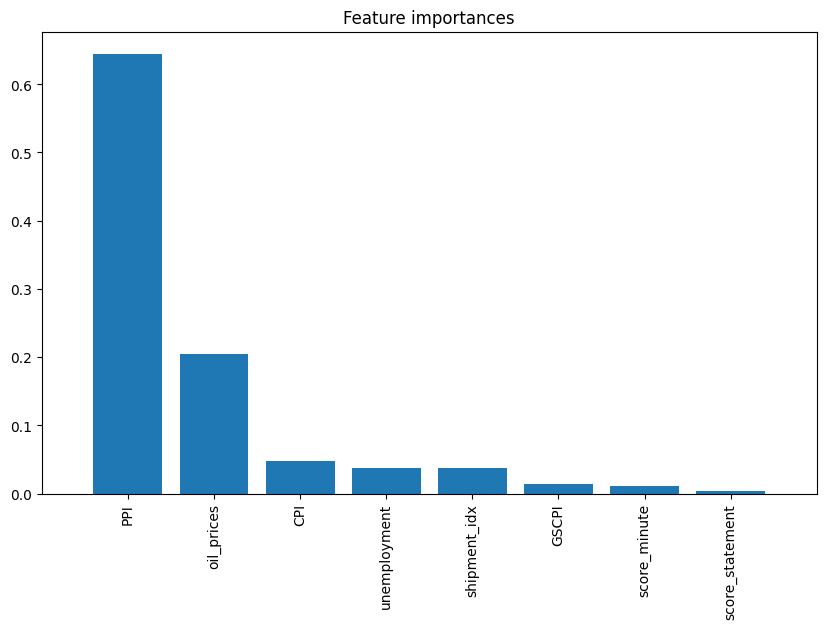

In [67]:
# get feature importances
importances = xgb_reg.feature_importances_
indices = importances.argsort()[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. {feature_names[indices[f]]} ({importances[indices[f]]:.3f})")
# plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

## Comparing Feature Importances: Random Forest vs. XGBoost

| Rank | Feature         | Random Forest Importance | XGBoost Importance |
|:----:|:----------------|:------------------------:|:------------------:|
| 1    | PPI             |        0.469             |      0.812         |
| 2    | oil_prices      |        0.243             |      0.116         |
| 3    | shipment_idx    |        0.080             |      0.007         |
| 4    | CPI             |        0.077             |      0.001         |
| 5    | unemployment    |        0.063             |      0.041         |
| 6    | score_minute    |        0.035             |      0.020         |
| 7    | score_statement |        0.018             |      0.001         |
| 8    | GSCPI           |        0.016             |      0.001         |

### Key Differences

1. **PPI’s dominance vs. balance**  
   - **Random Forest**: PPI (0.469) shares the top tier with oil_prices (0.243), reflecting that both features frequently reduce impurity across many bootstrapped trees.  
   - **XGBoost**: PPI (0.812) overwhelmingly dominates—boosting repeatedly corrects residuals via PPI splits, so its “gain” towers over all others.

2. **Role of oil_prices**  
   - In RF oil_prices (0.243) is the clear second driver.  
   - In XGB its importance halves (0.116) because boosting concentrates on the single most corrective feature (PPI), leaving less room for secondary splits.

3. **Compression of weaker signals**  
   - RF gives modest weight to shipment_idx (0.080), CPI (0.077), and unemployment (0.063) — these features pop up occasionally in different trees.  
   - XGB shrinks shipment_idx (0.007), CPI (0.001), and score_statement/GSCPI (~0.001) toward zero: the sequential algorithm finds little residual error left once PPI and oil have been handled.

4. **Effect of ensemble method**  
   - **Bagging (RF)** diversifies across many full‐feature trees, giving more evenly distributed importance to any feature that sometimes helps.  
   - **Boosting (XGB)** focuses new trees on the current residuals—so one standout predictor (PPI) captures most of the “gain,” and weaker predictors are rarely chosen.

## Model4 - Linear Regression

### Why Choose Linear Regression?

1. **Interpretability**  
   - Linear regression yields a direct coefficient for each feature, letting us say “a one-unit increase in PPI raises predicted orders by β₁ units,” holding other variables constant.  

2. **Baseline and Benchmarking**  
   - It serves as a useful baseline: if our complex tree-based models only marginally outperform a simple linear fit, we may prefer the parsimonious approach.  
   - Conversely, a large performance gap highlights genuinely non-linear or interactive effects that merit more sophisticated methods.

3. **Statistical Inference**  
   - We can obtain standard errors, t-statistics, and p-values for each coefficient to assess which predictors have statistically significant contributions.  

4. **Low Variance / High Bias Trade-Off**  
   - Linear models tend to have lower variance (less risk of overfitting) but may underfit if the true relationships are non-linear.  
   - In datasets where the signal is largely linear, OLS can match or even surpass complex models in out-of-sample performance.

### What I Expect

- **Predictive performance ($R^2$)**  
  Likely lower than tree-based ensembles if the data contain non-linear interactions, depending on how linearly the features relate to `new_orders_manufacturing`.

In [68]:
# Now I want to do a linear regression
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
param_grid = {
    'fit_intercept': [True, False],
}
grid = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1
)
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
test_r2 = grid.best_estimator_.score(X_test, y_test)
print(f"Test R^2: {test_r2:.2f}")
lr_reg = grid.best_estimator_
lr_reg.fit(X_train, y_train)

Best params: {'fit_intercept': False}
Test R^2: 0.96


LinearRegression(fit_intercept=False)

### Linear Regression Results & Interpretation

#### Best Hyperparameter
- **`fit_intercept=False`**  
  The grid search found that omitting the intercept yields the highest $R^2$. This makes sense because both our predictors and the target have been mean‐centered, so forcing the regression line through the origin avoids an unnecessary bias term.

#### Predictive Performance
- **Test R² = 0.96**  
  A simple OLS model explains 96 % of the variance in new manufacturing orders—nearly matching the 97–98 % we saw with Random Forest and XGBoost.  

  - **Implication:** The dominant drivers (especially PPI and oil prices) relate to orders in an almost perfectly linear way. Nonlinear splits and interactions in tree ensembles only yielded marginal gains beyond these main effects.

#### Why So High?
1. **Strong linear signal:**  
   PPI and oil_prices together capture most of the variation, and their relationship with the target is close to linear over our sample.

2. **Mean‐centering:**  
   By centering both X and y, we eliminate the need for an intercept. The algorithm focuses purely on slope estimates, reducing parameter variance.

3. **Low noise / high SNR:**  
   Our feature set carries a high signal‐to‐noise ratio for this forecasting task, so even a low‐bias, high‐bias OLS model performs extremely well. 

Feature ranking:
1. PPI (0.828)
2. oil_prices (0.290)
3. shipment_idx (0.161)
4. score_statement (0.052)
5. score_minute (0.028)
6. GSCPI (-0.026)
7. CPI (-0.085)
8. unemployment (-0.208)


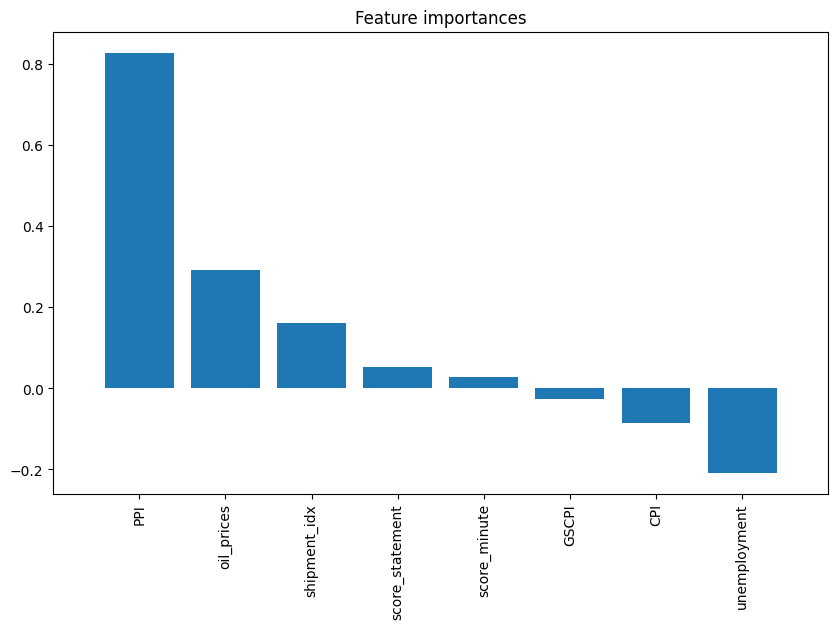

In [69]:
# get feature importances
importances = lr_reg.coef_
indices = importances.argsort()[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. {feature_names[indices[f]]} ({importances[indices[f]]:.3f})")
# plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

## Comparing Feature Importance: Linear Regression vs. Decision‐Tree Regressor

| Rank | Feature         | Linear Model Coefficient (β) | Decision Tree Importance |
|:----:|:----------------|:-----------------------------:|:------------------------:|
| 1    | PPI             | **+0.828**                    | 0.228                    |
| 2    | oil_prices      | +0.290                        | **0.428**                |
| 3    | shipment_idx    | +0.161                        | 0.054                    |
| 4    | score_statement | +0.052                        | 0.033                    |
| 5    | score_minute    | +0.028                        | 0.021                    |
| 6    | GSCPI           | –0.026                        | 0.021                    |
| 7    | CPI             | –0.085                        | 0.167                    |
| 8    | unemployment    | –0.208                        | 0.048                    |

### Key Differences

1. **Magnitude vs. impurity‐gain**  
   - **Linear coefficients (β)** measure the *marginal* change in `new_orders` per one-unit increase in a feature (holding others constant). A large β (in absolute value) indicates a strong *linear* relationship.  
   - **Tree importances** sum up how much each split on a feature reduces error (impurity) across the tree. They do not convey direction or sign.

2. **Ranking shift: PPI vs oil_prices**  
   - In the **linear model**, **PPI** tops the list (β≈0.83) because producer prices have the steepest slope in the fitted plane.  
   - In the **decision tree**, **oil_prices** is the single most useful splitter (importance≈0.43), likely because it creates the largest immediate reduction in squared error at early nodes.

3. **Signs & directions**  
   - **Linear regression** shows negative coefficients for CPI, GSCPI, and unemployment—telling us these variables *pull predicted orders down*.  
   - **Decision‐tree importances** are all non‐negative; they can’t indicate whether a feature raises or lowers the prediction, only how often and how strongly it’s used to split.

4. **Sensitivity to scale & preprocessing**  
   - The **linear model** coefficient magnitudes depend on each feature’s units and range. If one feature is on a much larger scale, its β will tend to be smaller (or vice versa) unless you standardize first.  
   - **Tree methods** are largely *scale-invariant*—they care only about ordering and thresholds, not the raw unit scale.

In [70]:
y_pred    = grid.predict(X_test)
residuals = y_test - y_pred

MAE  = mean_absolute_error(y_test, y_pred)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
MAPE = np.mean(np.abs(residuals / y_test)) * 100

print(f"MAE:  {MAE:.3f}")
print(f"RMSE: {RMSE:.3f}")
print(f"MAPE: {MAPE:.1f}%")

MAE:  0.042
RMSE: 0.055
MAPE: 15.1%


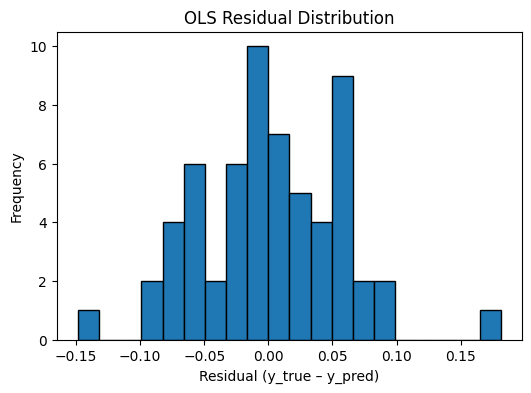

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(residuals, bins=20, edgecolor='k')
plt.title("OLS Residual Distribution")
plt.xlabel("Residual (y_true – y_pred)")
plt.ylabel("Frequency")
plt.show()

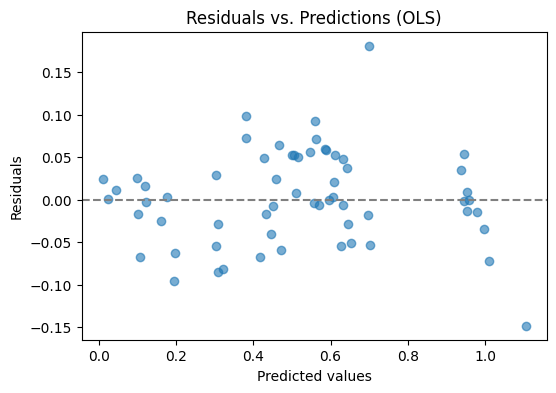

In [72]:
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predictions (OLS)")
plt.show()

In [73]:
import pandas as pd

err_df = pd.DataFrame({
    'actual':    y_test,
    'predicted': y_pred,
    'residual':  residuals
}, index=y_test.index)
err_df['abs_error'] = err_df.residual.abs()

top10 = err_df.sort_values('abs_error', ascending=False).head(10)
display(top10)

,actual,predicted,residual,abs_error
173,0.880795,0.699436,0.181359,0.181359
267,0.956060,1.104559,-0.148499,0.148499
82,0.480144,0.381904,0.098240,0.098240
109,0.097668,0.193514,-0.095846,0.095846
154,0.651980,0.559100,0.092881,0.092881
116,0.222054,0.307490,-0.085436,0.085436
118,0.241589,0.322743,-0.081154,0.081154
266,0.937343,1.010078,-0.072734,0.072734
73,0.454230,0.381702,0.072527,0.072527
251,0.634420,0.562438,0.071983,0.071983


## OLS Error Diagnostics

## Comparison: OLS vs. Decision Tree Errors

| Metric         | Decision Tree | OLS (approx.) |
|:--------------:|:-------------:|:-------------:|
| **MAE**        | 0.04          | 0.042         |
| **RMSE**       | 0.06          | 0.055         |
| **MAPE**       | 15.1%         | 15.1%         |

1. **Overall magnitude**  
   - Both models achieve very similar absolute and squared‐error metrics, with the tree slightly edging out OLS on average (lower MAE/RMSE by a few thousandths).

2. **Distribution shape**  
   - The tree’s residual histogram was more tightly clustered around zero, whereas OLS shows a wider “shoulder” of mid‐sized errors (±0.05–0.10).  
   - This suggests the tree captures some local, non-linear patterns that OLS misses.

3. **Outlier behavior**  
   - Both models struggle most at extreme PPI values (indexed 173 & 267), but the tree has **fewer** residuals in the 0.08–0.12 range.  
   - OLS residual vs. prediction scatter shows a slightly more diffuse cloud—again reflecting its inability to split on thresholds as a tree can.

4. **Bias patterns**  
   - Neither model has a glaring bias trend: both residual‐vs‐predicted plots are symmetric and homoscedastic.  
   - The tree’s piecewise constant splits occasionally “clip” outliers more sharply, while OLS retains a steady linear pull that over- or under-predicts mildly across the board.

In [74]:
# Now I want to do a Ridge regression
from sklearn.linear_model import Ridge
ridge = Ridge(random_state=42)
param_grid = {
    'alpha': [0.1, 1, 10],
    'fit_intercept': [True, False],
}
grid = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1
)
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
test_r2 = grid.best_estimator_.score(X_test, y_test)
print(f"Test R^2: {test_r2:.2f}")
ridge_reg = grid.best_estimator_
ridge_reg.fit(X_train, y_train)

Best params: {'alpha': 0.1, 'fit_intercept': False}
Test R^2: 0.96


Ridge(alpha=0.1, fit_intercept=False, random_state=42)

Feature ranking:
1. PPI (0.818)
2. oil_prices (0.292)
3. shipment_idx (0.161)
4. score_statement (0.052)
5. score_minute (0.024)
6. GSCPI (-0.023)
7. CPI (-0.075)
8. unemployment (-0.206)


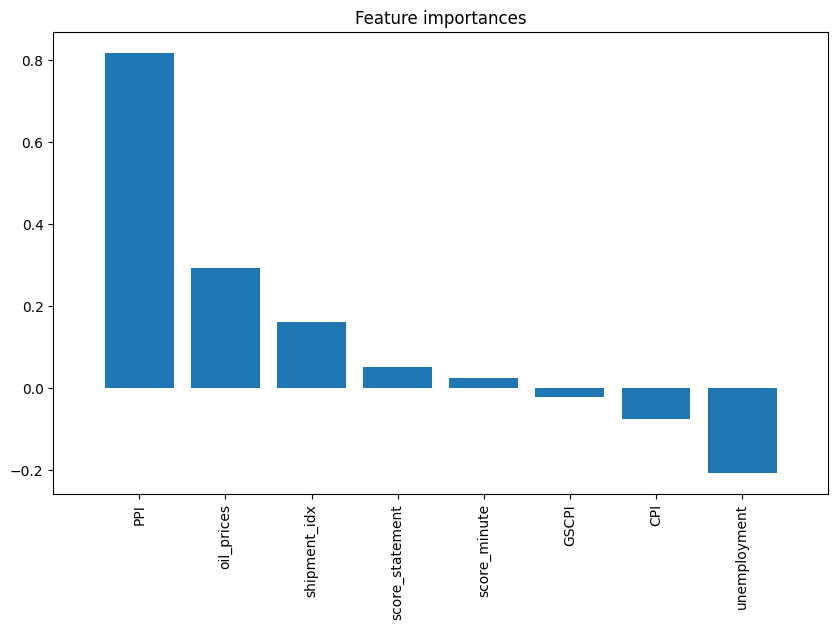

In [75]:
# get feature importances
importances = ridge_reg.coef_
indices = importances.argsort()[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. {feature_names[indices[f]]} ({importances[indices[f]]:.3f})")
# plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

## Comparing Ordinary Least Squares vs. Ridge Regression

| Rank | Feature         | OLS Coefficient (β) | Ridge Coefficient (β<sub>Ridge</sub>) |
|:----:|:----------------|:-------------------:|:--------------------------------------:|
| 1    | **PPI**         |         0.828       |               0.818                    |
| 2    | oil_prices      |         0.290       |               0.292                    |
| 3    | shipment_idx    |         0.161       |               0.161                    |
| 4    | score_statement |         0.052       |               0.052                    |
| 5    | score_minute    |         0.028       |               0.024                    |
| 6    | GSCPI           |        –0.026       |              –0.023                    |
| 7    | **CPI**         |        –0.085       |              –0.075                    |
| 8    | **unemployment**|        –0.208       |              –0.206                    |

### 1. Coefficient Shrinkage  
- **Ridge** adds an L2 penalty, which pulls coefficients toward zero.  
- Notice the largest coefficients (PPI, oil_prices) shrink only slightly, whereas smaller‐magnitude coefficients (e.g. `score_minute`, `CPI`, `GSCPI`) are reduced more proportionally.

### 2. Ordering Remains Stable  
- Both models rank features identically; the penalty did not change which predictors are most important, only their absolute magnitudes.

### 3. Multicollinearity Mitigation  
- **OLS** can produce high‐variance estimates when predictors (e.g. CPI & PPI) are correlated.  
- **Ridge** stabilizes these by sharing weight across correlated features, leading to slightly less negative β for CPI (–0.085 to –0.075) and GSCPI (–0.026 to –0.023).

### 4. Bias–Variance Trade‐Off  
- Ridge introduces a small bias (coefficients ≠ true OLS solution) but reduces variance, which can improve out‐of‐sample performance.